In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator
import time
import pickle
import os
import matplotlib.patheffects as pe


In [2]:
fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


In [3]:
df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')
df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,q11,q12,q22,Rc,psi0,A,R,Age,Date,fname
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,1.099922,-0.193920,0.943344,104.677927,71.391686,-0.006515,69.250036,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,1.066764,-0.119714,0.950849,110.542281,77.351002,-0.006330,62.000626,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,1.016800,-0.154298,1.006892,115.245476,75.250400,-0.005666,67.000485,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,0.896874,-0.276325,1.200119,114.738549,72.789618,-0.005529,66.501582,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,0.847358,-0.169788,1.214160,100.425496,58.705551,-0.005821,56.251116,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105233,2631,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,0.898473,0.197470,1.156400,114.894173,-41.491437,0.003143,72.751791,24,2019-02-24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
105234,2631,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,0.884289,0.308226,1.238286,111.853372,-42.195517,0.003373,73.000933,24,2019-02-25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
105235,2631,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,0.883521,0.168561,1.163994,107.180060,-43.102690,0.003752,75.750780,24,2019-02-26,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
105236,2631,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,0.873263,0.225002,1.203104,100.368133,-37.967048,0.003769,75.750006,24,2019-02-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


### Smooth out paramters for plotting

In [4]:
def smooth(x, y, num=1000, window=100):

    from scipy.interpolate import interp1d
    """
    Smooth x vs y by:
      1) interpolating onto a uniform y-grid
      2) applying a running nan‑mean of width `window`
      3) interpolating back to the original y

    Any output point whose window contains only NaNs will be NaN.
    """
    x = np.asarray(x, float)
    y = np.asarray(y, float)

    # 1) uniform y grid & interpolation
    y_uniform = np.linspace(y.min(), y.max(), num)
    f_interp = interp1d(y, x, kind='linear', fill_value='extrapolate')
    x_uniform = f_interp(y_uniform)

    # 2) running nan-mean on the uniform grid
    def moving_nanmean(a, win):
        """Return an array the same size as a, where each point is the mean of
        the surrounding win points (including itself), ignoring NaNs."""
        valid = ~np.isnan(a)
        # fill NaNs with zero so they don't contribute to sum
        a_fill = np.where(valid, a, 0.0)
        # convolution kernels
        kernel = np.ones(win, dtype=float)
        # sums of valid data
        sums   = np.convolve(a_fill, kernel, mode='same')
        # counts of valid entries
        counts = np.convolve(valid.astype(float), kernel, mode='same')
        # compute mean; outside domain or where counts==0 gives NaN
        with np.errstate(divide='ignore', invalid='ignore'):
            mu = sums / counts
        mu[counts == 0] = np.nan
        return mu

    x_smooth_uniform = moving_nanmean(x_uniform, window)

    # 3) back to original y
    f_smooth = interp1d(y_uniform, x_smooth_uniform,
                        kind='linear', fill_value='extrapolate')
    x_smooth = f_smooth(y)

    return x_smooth

    

In [5]:
# apply smoothing function to Q and Rc values

sQ_col = [None] * len(df_eddies)
sRc_col = [np.nan] * len(df_eddies)
spsi0_col = [np.nan] * len(df_eddies)
for eddy, grp in df_eddies.groupby('Eddy'):
    idx = grp.index.to_list()

    # time axis for smoothing
    ds = np.arange(len(grp))

    q11 = grp['q11'].to_numpy(float)
    q12 = grp['q12'].to_numpy(float)
    q22 = grp['q22'].to_numpy(float)

    Rcs = grp['Rc'].to_numpy(float)
    psi0s = grp['psi0'].to_numpy(float)

    window = 5  # 5 day smoothign window
    sq11 = smooth(q11, ds, num=len(ds), window=window)
    sq12 = smooth(q12, ds, num=len(ds), window=window)
    sq22 = smooth(q22, ds, num=len(ds), window=window)
    sRc  = smooth(Rcs, ds, num=len(ds), window=window) 
    spsi0  = smooth(psi0s, ds, num=len(ds), window=window) 

    # build 2x2 matrix per time step, and write back per row
    sQ_list = [np.array([[a, b], [b, c]], float) for a, b, c in zip(sq11, sq12, sq22)]
    for k, i in enumerate(idx):
        sQ_col[i]  = sQ_list[k]
        sRc_col[i] = sRc[k]
        spsi0_col[i] = spsi0[k]

df_eddies['sQ']  = sQ_col
df_eddies['sRc'] = sRc_col
df_eddies['spsi0'] = spsi0_col


### Plotting function

In [6]:
def day_plot(day, df_eddies):

    fnumber = 1461 + ((day - 1462) // 30)*30
    fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_{fnumber:05}.nc'
    dataset = nc.Dataset(fname)
    u_east = np.transpose(dataset['u_eastward'][:].data, axes=(3, 2, 1, 0))[:, :, -1, :].squeeze()
    v_north = np.transpose(dataset['v_northward'][:].data, axes=(3, 2, 1, 0))[:, :, -1, :].squeeze()
    ocean_time = dataset.variables['ocean_time'][:].data / 86400
    t = np.where(day==ocean_time)[0][0]
    ut, vt = u_east[:, :, t], v_north[:, :, t] # these are the surface velocities for that day in SEACOFS model

    df_day = df_eddies[df_eddies.Day.eq(day)] # Eddy df for that day

    cs = np.hypot(ut, vt)

    fig, ax = plt.subplots(figsize=(8, 10))
    # im = ax.pcolormesh(X_grid, Y_grid, cs, shading='nearest', vmin=0, vmax=2.5, cmap='Blues_r')
    im = ax.pcolor(X_grid, Y_grid, cs, shading='nearest', vmin=0, vmax=2.5, cmap='Blues_r')
    fig.colorbar(im, ax=ax, label=r'Current Speed [ms$^{-1}$]')

    clrs = np.where(df_day.Cyc.eq('CE'), 'c', 'r')
    ax.scatter(df_day.xc, df_day.yc, c=clrs, edgecolors='k', linewidths=0.8, s=60, zorder=10)

    for xc, yc, e, Q, Rc, cyc in zip(df_day.xc, df_day.yc, df_day.Eddy, df_day.sQ, df_day.sRc, df_day.Cyc):

        # ----- Where I plot the eddy's maximum tangenital velocity contour -----
        dx_ell, dy_ell = X_grid - xc, Y_grid - yc
        rho2_ell = Q[0,0]*dx_ell**2 + 2*Q[1,0]*dx_ell*dy_ell + Q[1,1]*dy_ell**2 # rho^2
        ax.contour(X_grid, Y_grid, rho2_ell, levels=[Rc**2/2], colors='r' if cyc=='AE' else 'c')
        # -----------------------------------------------------------------------

        ax.annotate(
            str(e), (xc, yc),
            textcoords='offset points', xytext=(3, 3),
            fontsize=12, color='w', weight='bold',
            path_effects=[pe.withStroke(linewidth=2, foreground='k')],
            zorder=11
        )

    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=[-40, -35, -30, -25], colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=[150, 155, 160], colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
                
    ax.set_title(f'Day {day} | {pd.Timestamp("1990-01-01") + pd.Timedelta(days=day)}')
    ax.set_aspect('equal', adjustable='datalim')
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')
    ax.set_xlim(x_grid.min(), x_grid.max())
    ax.set_ylim(y_grid.min(), y_grid.max())
    


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
/home/z5297792/myenv310/lib/python3.10/site-packages/matplotlib/colors.py:778: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


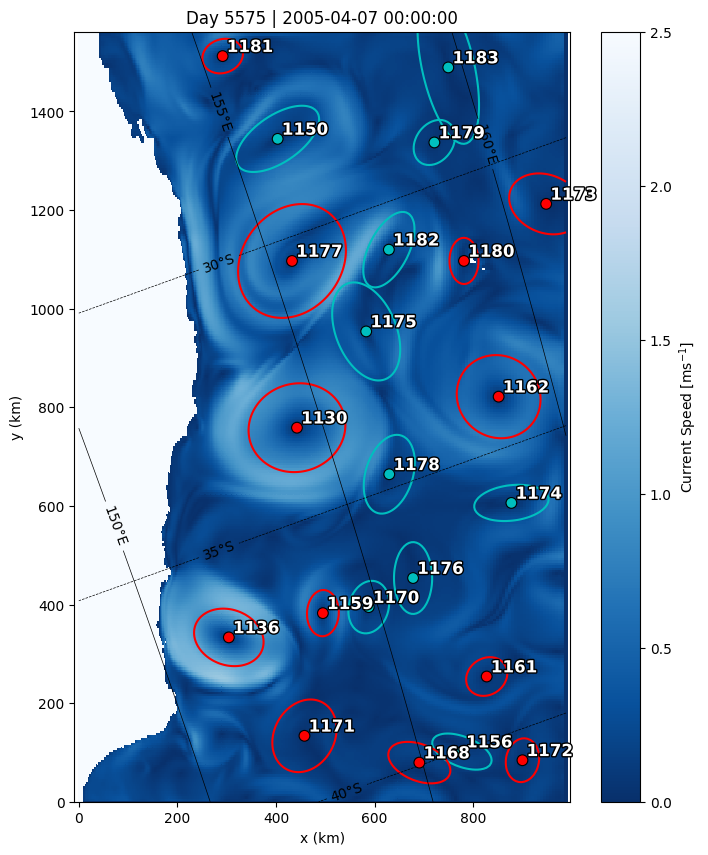

In [7]:
# choose what day you want to plot
day = 5575

day_plot(day, df_eddies)


Kabirs idea: Sum up all the streamfunctions for a particualr day and see how they interact.



In [8]:
def day_plot_eddy(day, df_eddies):
    
    df_day = df_eddies[df_eddies.Day==day]
    
    psi = np.full_like(X_grid, 0)
    fig, ax = plt.subplots(figsize=(8, 10))
    for eddy in df_day.Eddy:
        data = df_day[df_day.Eddy==eddy].iloc[0]
        dx, dy = X_grid - data.xc, Y_grid - data.yc
        rho2 = data.sQ[0,0]*dx**2 + 2*data.sQ[1,0]*dx*dy + data.sQ[1,1]*dy**2
        psi += data.spsi0 * np.exp( - rho2 / data.sRc**2 )
    
        ax.scatter(data.xc, data.yc, c='c' if data.Cyc =='CE' else 'r',
                   edgecolors='k', linewidths=0.8, s=60, zorder=10)
    
        ax.contour(X_grid, Y_grid, rho2, levels=[data.sRc**2/2],
                   colors='r' if data.Cyc=='AE' else 'c', zorder=10)
    
        ax.annotate(
            str(eddy), (data.xc, data.yc),
            textcoords='offset points', xytext=(3, 3),
            fontsize=12, color='w', weight='bold',
            path_effects=[pe.withStroke(linewidth=2, foreground='k')],
            zorder=11
        )
    
    dpsi_dx, dpsi_dy = np.gradient(np.where(mask_rho, psi, np.nan), x_grid, y_grid)  # returns [∂ψ/∂y, ∂ψ/∂x]
    u = -dpsi_dy
    v =  dpsi_dx

    im = ax.pcolor(X_grid, Y_grid, np.hypot(u, v), cmap='Blues_r', vmin=0)
    fig.colorbar(im, ax=ax, label=r'Current Speed [ms$^{-1}$]')
    spac = 5
    ax.quiver(X_grid[::spac, ::spac], Y_grid[::spac, ::spac],
                   u[::spac, ::spac], v[::spac, ::spac], width=.001)
    
    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=[-40, -35, -30, -25], colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=[150, 155, 160], colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    
    ax.set_title(f'Day {day} | {pd.Timestamp("1990-01-01") + pd.Timedelta(days=day)}')
    ax.set_aspect('equal', adjustable='datalim')
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')
    ax.set_xlim(x_grid.min(), x_grid.max())
    ax.set_ylim(y_grid.min(), y_grid.max())


In [9]:
max_eddys = []
for day in df_eddies.Day.unique():
    max_eddys.append(len(df_eddies[df_eddies.Day==day]))
df_days = pd.DataFrame({'Day': df_eddies.Day.unique(), 'num_eddies': max_eddys})
df_days[df_days.num_eddies==df_days.num_eddies.max()]


,Day,num_eddies
0,1462,8
1,1463,10
2,1464,11
3,1465,12
4,1466,13
...,...,...
9184,10646,5
9185,10647,5
9186,10648,5
9187,10649,5


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


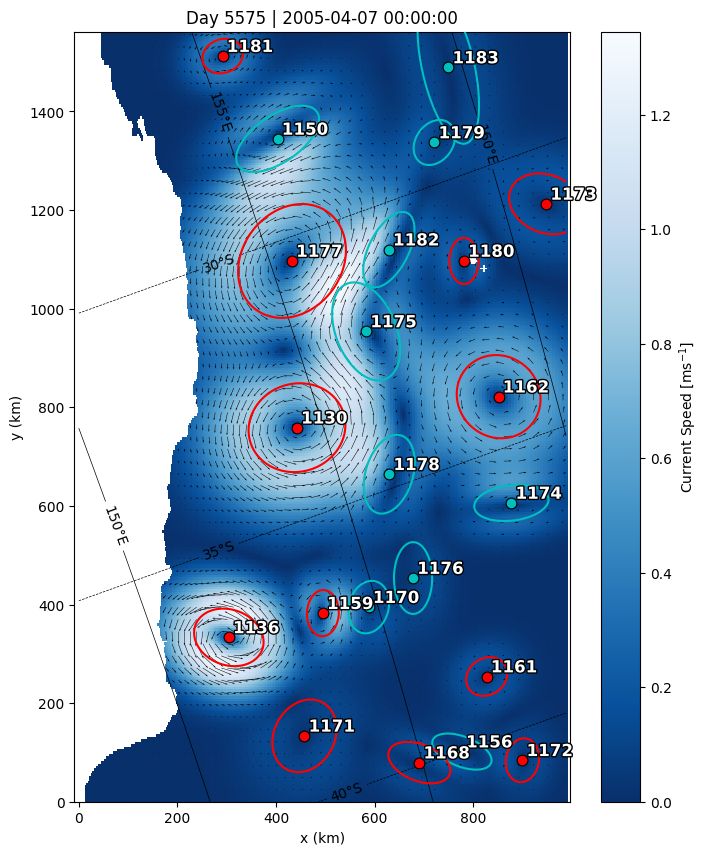

In [15]:
day_plot_eddy(5575, df_eddies)


In [12]:
def day_plot_background(day, df_eddies):

    fnumber = 1461 + ((day - 1462) // 30)*30
    fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_{fnumber:05}.nc'
    dataset = nc.Dataset(fname)
    u_east = np.transpose(dataset['u_eastward'][:].data, axes=(3, 2, 1, 0))[:, :, -1, :].squeeze()
    v_north = np.transpose(dataset['v_northward'][:].data, axes=(3, 2, 1, 0))[:, :, -1, :].squeeze()
    ocean_time = dataset.variables['ocean_time'][:].data / 86400
    t = np.where(day==ocean_time)[0][0]
    ut, vt = u_east[:, :, t], v_north[:, :, t] # these are the surface velocities for that day in SEACOFS model

    df_day = df_eddies[df_eddies.Day.eq(day)] # Eddy df for that day

    # cs = np.hypot(ut, vt)

    fig, ax = plt.subplots(figsize=(8, 10))
    # im = ax.pcolormesh(X_grid, Y_grid, cs, shading='nearest', vmin=0, vmax=2.5, cmap='Blues_r')
    # fig.colorbar(im, ax=ax, label=r'Current Speed [ms$^{-1}$]')

    clrs = np.where(df_day.Cyc.eq('CE'), 'c', 'r')
    ax.scatter(df_day.xc, df_day.yc, c=clrs, edgecolors='k', linewidths=0.8, s=60, zorder=10)

    psi = np.full_like(X_grid, 0)
    for xc, yc, e, Q, Rc, psi0, cyc in zip(df_day.xc, df_day.yc, df_day.Eddy, df_day.sQ, df_day.sRc, df_day.spsi0, df_day.Cyc):

        # ----- Where I plot the eddy's maximum tangenital velocity contour -----
        dx_ell, dy_ell = X_grid - xc, Y_grid - yc
        rho2_ell = Q[0,0]*dx_ell**2 + 2*Q[1,0]*dx_ell*dy_ell + Q[1,1]*dy_ell**2 # rho^2
        ax.contour(X_grid, Y_grid, rho2_ell, levels=[Rc**2/2], colors='r' if cyc=='AE' else 'c')
        # -----------------------------------------------------------------------

        ax.annotate(
            str(e), (xc, yc),
            textcoords='offset points', xytext=(3, 3),
            fontsize=12, color='w', weight='bold',
            path_effects=[pe.withStroke(linewidth=2, foreground='k')],
            zorder=11
        )
        psi += psi0 * np.exp( - rho2_ell / Rc**2 )

    dpsi_dx, dpsi_dy = np.gradient(np.where(mask_rho, psi, np.nan), x_grid, y_grid)  # returns [∂ψ/∂y, ∂ψ/∂x]
    u = -dpsi_dy
    v =  dpsi_dx

    u_b, v_b = ut - u , vt - v
    cs = np.hypot(u_b, v_b)
    im = ax.pcolormesh(X_grid, Y_grid, cs, shading='nearest', vmin=0, vmax=None, cmap='Blues_r')
    fig.colorbar(im, ax=ax, label=r'Current Speed [ms$^{-1}$]')
    

    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=[-40, -35, -30, -25], colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=[150, 155, 160], colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
                
    ax.set_title(f'Day {day} | {pd.Timestamp("1990-01-01") + pd.Timedelta(days=day)}')
    ax.set_aspect('equal', adjustable='datalim')
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')
    ax.set_xlim(x_grid.min(), x_grid.max())
    ax.set_ylim(y_grid.min(), y_grid.max())
    

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


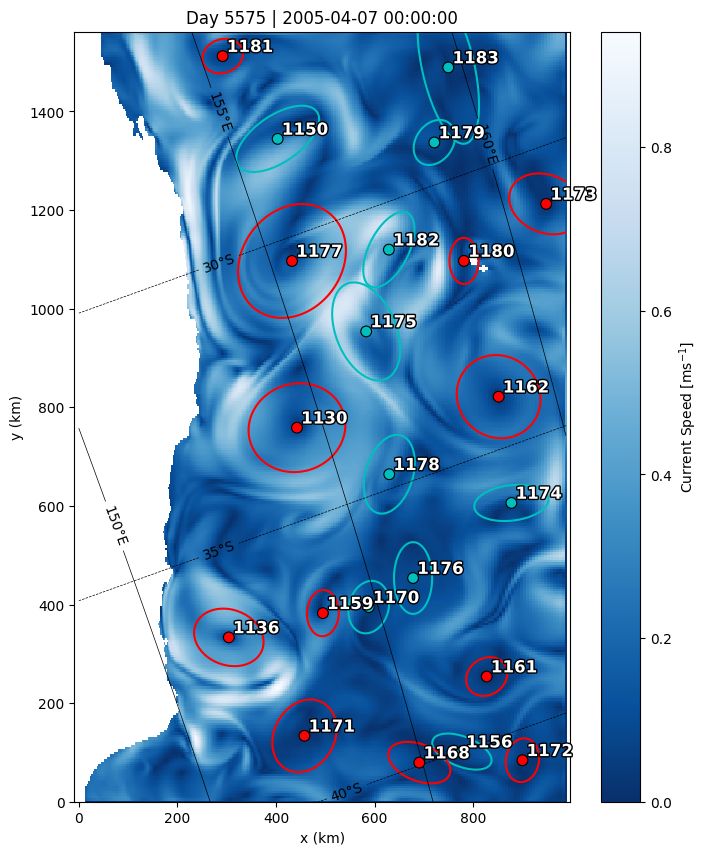

In [14]:
day_plot_background(5575, df_eddies)
